# Overview
*By Yikang Wang*

Udacity's free A/B Testing course (https://classroom.udacity.com/courses/ud257)

This course covers the content: 

1) Overview of A/B Testing <br>
2) Policy and Ethic for Experiment <br>
3) Choosing and Characterizing Metric <br>
4) Designing and Experiment <br> 
5) Analyzing results. 

Reference and credits to 
1. Tammy Rotem: https://www.kaggle.com/tammyrotem/ab-tests-with-python
2. Andrew Bauman: https://github.com/baumanab/udacity_ABTesting#summary
3. Ella Wan https://medium.com/@moggirain/a-complete-guide-about-a-b-testing-a1830410a0db

In [42]:
import math as mt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load packages

In this case, the goal of measurement is how many students will allocate more than 5 hours a week for Udacity courses, which happens before students enrolling in the courses. And thus the clicks and cookies related metircs are for the invariant metircs.User-id, however, will be tracked after enrolling the course,which is not effective. <br>

Here, we are concerned about whether students click the "free trial" and if students' clicks for the answer to questions about the number of hours they will devote to the course, and thus clicks and cookies are important. Number of cookies is used to tell whether the change is from the questions or not. 

# Experiment_Free Trial

## Experiment Description

At the time of this experiment, Udacity courses currently have two options on the course overview page: "start free trial", and "access course materials". <br>

If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first.

If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.


## Experiment Goal

To improve the overall student experience and completion rate of Udacity courses through allocating coaches' capacity to support students who are likely to complete the course.

## Hypothesis

The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course. If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

## Unit of Diversion

The ***unit of diversion*** is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. 

The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

# Metrics

<a class="anchor" id="metric"></a>
Here two types of metrics are selected for a successful experiment: Invariate and Evaluation metrics.

***Invariate metircs*** are used for sanity checks or A/A experiment before running the experiment, such as checking if the distributions are the same between control and experiment group, to make sure our experiment is not inherently wrong. Invariant metrics usually have a larger unit of diversion, randomly selected, or happens before the experiment starts.  

***Evaluation metrics*** are the metrics in which we expect to see a change, and are relevant to the business goals we aim to achieve. For each metric we state a $Dmin$ - which marks the minimum change which is practically significant to the business. For instance, stating that any increase in retention that is under 2%, even if statistically significant, is not practical to the business.

## Invariant Metric

Invariate Metrics - Sanity Checks <a class="anchor" id="invariate"></a>

| Metric Name  | Metric Formula  | $Dmin$  | Notation |
|:-:|:-:|:-:|:-:|
| Number of Cookies in Course Overview Page  | # unique daily cookies on page | 3000 cookies  | $C_k$ |
| Number of Clicks on Free Trial Button  | # unique daily cookies who clicked  | 240 clicks | $C_l$ |
| Free Trial button Click-Through-Probability  | $\frac{C_l}{C_k}$ | 0.01  | $CTP$ | 


## Evaluation Metric 

Evaluation Metrics - Performance Indicators <a class="anchor" id="evaluation"></a>

| Metric Name  | Metric Formula  | $Dmin$  | Notation |
|:-:|:-:|:-:|:-:|
| Gross Conversion   |  $\frac{enrolled}{C_l}$  | 0.01  | $Conversion_{Gross}$ |
| Retention   | $\frac{paid}{enrolled}$  | 0.01  | $Retention$ |
| Net Conversion  |  $\frac{paid}{C_l}$  | 0.0075 | $Conversion_{Net}$ |

Here, CTP won't be a good evaluation metrics, given it can not distinguish the change of free trial between the experiment and control group. <br>

Gross Conversion will be a good metric. Gross conversion means the number of enrolled divided by number of clicks. And thus in the experiment group, we hypothesized the number of enrollment will decrease after answering the screener questions, given those who selected <5 hour will not be encouraged to enroll. <br>

Retention is number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by number of enrolled students. Udacity could use this metric to check if the the number of paid students are decreasing or not by this test.If the hypothesis is true, the number of students who try free trial reduces without reducing the number of students who are enrolled past 14 days. This means that retention will increase. <br> 

Net conversion is number of user-ids to remain enrolled past the 14-day boundary (and thus make at least one payment) divided by the number of unique cookies to click the ”Start free trial” button. This metric is also necessary because of the same reason described in Retention. If the hypothesis hold true, the number of students who remain enrolled past 14 days won’t change so much. Therefore, this metric also doesn’t change.

# Estimating The Baseline Values 

Before starting the experiment, we should know how these metrics behave before the change - that is, what are their baseline values.

## Collecting estimators data

<a class="anchor" id="collect"></a>
Udacity offers the following rough estimates for these metrics (presumably collected from aggregates on daily traffic) <br>

| Item | Description  | Estimator  |
|:-:|:-:|:-:|
| Number of cookies | Daily unique cookies to view course overview page  | 40,000  |
| Number of clicks | Daily unique cookies to click Free Trial button  | 3,200 |
| Number of enrollments | Free Trial enrollments per day  | 660  |
| CTP | CTP on Free Trial button  | 0.08  |
| Gross Conversion | Probability of enrolling, given a click  | 0.20625  |
| Retention | Probability of payment, given enrollment  | 0.53  |
| Net Conversion | Probability of payment, given click  | 0.109313 |

In [43]:
# Store the baseline values into a dictionary
baseline = {"Cookies":40000,
            "Clicks":3200,
            "Enrollments":660,
            "CTP":0.08,
            "GConversion":0.20625,
            "Retention":0.53,
            "NConversion":0.109313}

## Estimating Standard Deviation <a class="anchor" id="sd"></a>
Once the estimates are collected, we should estimate the standard deviation of a metric. 
This is computed for ***sample size calculations*** and ***confidence intervals*** for our results. 

The more variant a metric is, the harder it is to reach a significant result. 

Assuming a sample size of 5,000 cookies visiting the course overview page per day (as given in project's instructions) - we want to estimate a standard deviation, for the evaluation metrics only. 

The sample size we are considering should be smaller than the "population" we collected and small enough to have two groups with that size. Given the sample size of 5000 pageviews for each metric, we will rescale the baseline values. 

In [44]:
# Rescale the counts estimates when sample = 5000
prop = 5000 / 40000
baseline['Cookies'] = 5000
baseline['Clicks'] = baseline['Clicks'] * prop
baseline['Enrollments'] = baseline['Enrollments'] * prop
baseline

{'Cookies': 5000,
 'Clicks': 400.0,
 'Enrollments': 82.5,
 'CTP': 0.08,
 'GConversion': 0.20625,
 'Retention': 0.53,
 'NConversion': 0.109313}

##  Standard Devisation <a class="anchor" id="estimate"></a>

In order to estimate variance analytically, we can assume metrics which are probabilities ($\hat{p}$) are binomially distributed, so we can use this formula for the standard deviation: <br>
<center><font size="4">$SD=\sqrt{\frac{\hat{p}*(1-\hat{p})}{n}}$</font></center><br>
This assumption is only valid when the **unit of diversion** of the experiment is equal to the **unit of analysis** (the denominator of the metric formula). In the cases when this is not valid, the actual variance might be different and it is recommended to estimate it empirically.

For each metric, we need to plug two variables into the formula: <br>
$\hat{p}$ - baseline probability of the event to occur <br>
$ n $ - sample size <br>




In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course. <br> 

The difference between experiment and control group will occur after clicking the start free trial. 

At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead. This screenshot ((https://drive.google.com/file/d/0ByAfiG8HpNUMakVrS0s4cGN2TjQ/view) shows what the experiment looks like.

What are A & B versions in this experiment?
(https://drive.google.com/file/d/1LUMaZt30y_j3c6OGYMoGf2EDLHdRetoU/view?usp=sharing)


We hypothesized that free trial screener set clearer expectations for students upfront and thus reduce the number of frustrated students who left the free trial because they didn't have enough time— without significantly reducing the number of students to continue pass the free trial and eventually complete the course. 

In [45]:
def standard_d (p, n, round_d = 4):
    return round(np.sqrt(p * (1 - p)/n),round_d)

### Gross Conversion 

The baseline probability for Gross Conversion can be calculated by the number of users to enroll in a free trial divided by the number of cookies clicking the free trial. In other words, the probability of enrollment given a click. 

In this case, the unit of diversion (Cookies), that is the element by which we differentiate samples and assign them to control and experiment groups, is equall to the unit of analysis (cookies who click), that is the denominator of the formula to calculate Gross Conversion (GC). When this is the case, this analytic estimate of variance is sufficient.

In [46]:
# and compute the Stansard Deviation(sd) rounded to 4 decimal digits.
GC={}
GC["d_min"]=0.01
GC["p"]=baseline["GConversion"]
GC["n"]=baseline["Clicks"]
GC["sd"] = standard_d(GC["p"], GC["n"], round_d = 4)
GC["sd"]

0.0202

### Retention

The baseline probability for retention is the number of paying users (enrolled after 14 free days) divided by the number of total enrolled users. 
In other words, the probability of payment, given enrollment. The sample size is the number of enrolled users. 
In this case, unit of diversion is not equal to unit of analysis (users who enrolled) so an analytical estimation is not enough - if we had the data for these estimates, we would want to estimate this variance empirically as well.

In [47]:
Rt={}
Rt["d_min"]=0.01
Rt["p"]=baseline["Retention"]
Rt["n"]=baseline["Enrollments"]
Rt["sd"]=standard_d(Rt["p"], Rt["n"], round_d = 4)
Rt["sd"]

0.0549

### Net Conversion 

The baseline probability for the net conversion is the number of paying users divided by the number of cookies that clicked the free trial button. In other words, the probability of payment, given a click. The sample size is the number of cookies that clicked. In this case, the unit of analysis and diversion are equal so we expect a good enough estimation analytically.

In [48]:
NC={}
NC["d_min"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]
NC["sd"]=standard_d(NC["p"], NC["n"], round_d = 4)
NC["sd"]

0.0156

***Analytical Estimate of Standard Deviation of Evaluation Metrics***

| Evaluation Metric | Standard Deviation |
|:-:|:-:|
|Gross Conversion|.0202 |
|Retention|	.0549 |
|Net Conversion	|.0156 |

# Experiment Sizing <a class="anchor" id="sizing"></a>
Once we have estimated our metrics in the baseline (most importantly, their estimated variance) we can calculate the minimal number of samples we need so that our experiment will have enough statistical power, as well as siginificance.

Given $\alpha=0.05$ (significance level ) and $\beta=0.2$ (power), we want to estimate how many total pageviews (cookies who viewed the course overview page) we need in the experiment. This amount will be divided into tthe two groups: control and experiment. This calculation can be done using an [online calculator](http://www.evanmiller.org/ab-testing/sample-size.html) or by calculating directly using the required formula.

The minimum sample size for control and experiment groups, which provides probability of Type I Error $\alpha$, Power $1-\beta$, detectable effect $d$ and baseline conversion rate $p$ (simple hypothesis $H_0 : P_{cont} - P_{exp} = 0$ against simple alternative $H_A : P_{cont} - P_{exp} = d$  is:

<center> <font size="5"> $n = \frac{(Z_{1-\frac{\alpha}{2}}sd_1 + Z_{1-\beta}sd_2)^2}{d^2}$</font>, with: <br><br>
$sd_1 = \sqrt{p(1-p)+p(1-p)}$<br><br>
$sd_2 = \sqrt{p(1-p)+(p+d)(1-(p+d))}$ </center><br>

Now, let's break down what inputs we need and which calculations still need to be made. Regarding inputs, we have all the data we need:
Type 1 error ($\alpha$), power ($1-\beta$), detectable change ($d = D_{min}$) and baseline conversion rate (our $\hat{p}$ ).
What we need to calculate: 
* Get Z score for $1-\frac{\alpha}{2}$ and for $1-\beta$
* Get standard deviations 1 & 2, that is for both the baseline and for expected changed rate
All these components will finally yield the number we need.

## Get z-score critical value and standard deviations 
We are used to looking up this value in a table, but gladly we can use python's scipy.stats.norm package to get all the required methods for normal distribution. The ppf method gives us access to the Percent Point Function (ppf) or Quantile Function, and besides it being the inverse of the Cummulative Distribution Function (cdf), this is the functions that will give back our required critical z-score.

In [49]:
#Inputs: required alpha value (alpha should already fit the required test)
#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

# Inputs p-baseline conversion rate which is our estimated p and d-minimum detectable change
# Returns
def get_sds(p,d):
    sd1 = np.sqrt(p * (1-p) + p * (1-p))
    sd2 = np.sqrt(p *(1-p) + (p + d)* (1-(p+d)))
    sds = [sd1, sd2]
    return sds

# Inputs:sd1-sd for the baseline,sd2-sd for the expected change,alpha,beta,d-d_min,p-baseline estimate p
# Returns: the minimum sample size required per group according to metric denominator
def get_sampSize(sds,alpha,beta,d):
    n = pow ((get_z_score(1 - alpha / 2) * sds[0] + get_z_score (1 - beta) * sds[1]),2) / pow(d,2)
    return n

## Calculate Sample Size per Metric <a class="anchor" id="calc"></a>
We are now going to calculate the number of samples required for the experiment per metric. This size should be considered in terms of efficacy of duration and exposure: how long will it take to get this many samples for the experiment.

***Pageviews for Each Evaluation Metric to Achieve Target Statistical Power***

### Gross Conversion

In [50]:
GC["SampSize"]=round(get_sampSize(get_sds(GC["p"],GC["d_min"]),0.05,0.2,GC["d_min"]))
# pageview for two groups
GC["SampSize_total"]=round(GC["SampSize"]/ 0.08 *2)
GC["SampSize_total"]

645875.0

Baseline Conversion: 20.625% <Br>
Minimum Detectable Effect: 1%
Alpha: 5% <br>
Beta: 20% <br>
Sensitivity (1 - Beta): 80% <br>
Sample Size = 25,835 clicks/group <br>
Number of groups = 2 (experiment and control)<br>
Total sample size = 51,670 clicks <br>
Clicks/Pageview: 3200/40000 = 0.08 <br>
Pageviews Required = 51,670 / 0.08 = 6,45,875

### Retention

In [51]:
# Getting an integer value 
Rt["SampSize"]=round(get_sampSize(get_sds(Rt["p"],Rt["d_min"]),0.05,0.2,Rt["d_min"]))
Rt["SampSize"]
# convert enrollment per group to the total number of clicks and to page views
Rt["SampSize_total"] = round(Rt["SampSize"] / 0.20625 / 0.08 * 2)
Rt["SampSize_total"]

4737818.0

This number is slightly different than what we calculate through the online calculator. 
Here is another version of answer. 

Baseline Conversion: 53% <br>
Minimum Detectable Effect: 1% <br>
Alpha: 5% <br>
Beta: 20% <br>
Sensitivity (1 - Beta): 80% <br>
Sample size = 39,155 enrollments/group <br>
Number of groups = 2 (experiment and control) <br>
Total sample size = 78,230 enrollments <br>
Enrollments/pageview: 660/40000 = 0.0165  <br>
Pageviews = 78,230/0.0165 = 47,41,212

### Net Conversion

In [52]:
NC["SampSize"]=round(get_sampSize(get_sds(NC["p"],NC["d_min"]),0.05,0.2,NC["d_min"]))
NC["SampSize_total"] = NC["SampSize"] * 2 / (3200/40000)
NC["SampSize_total"]

685325.0

Baseline Conversion: 10.9313% <br>
Minimum Detectable Effect: 1% <br>
Alpha: 5% <br>
Beta: 20% <br>
Sensitivity (1 - Beta): 80% <br>
Sample size = 27,413 clicks/group <br>
Number of groups = 2 (experiment and control) <br>
Total sample size = 54,826 clicks <br>
Clicks/pageview: 3200/40000 = 0.08  <br>
Pageviews = 54,826/0.08 = 6,85,325

Pageviews required is maximum of pageviews required for Gross Conversion, Retention, Net Conversion. Therefore, the required pageviews is 47,41,212.

## Duration and Exposure

If we divert 100% of traffic, given 40,000 page views per day, the experiment would take about 119 days.

This duration with full diversion is too time consuming for running an experiment and presents some potential risks for business, such as frustrated students, lower conversion and retention, and inefficient use of coaching resources, and the opportunity riks of performing other experiments. 

Therefore, if we eliminate retention, we are left with Gross Conversion and Net Conversion, and the pageview requirement will be reduced to  to 685,325, and an about 18 day experiment with 100% diversion and or 35 days given 50% diversion.In terms of timing, an 18 day experiment is more reasonable, but % diversion may be scaled down depending on other experiments of interest to be performed concurrently.

# Experimental Analysis

The last step is to prove the experiment using the actual data. Three parts are included in this section: 

1) Sanity Checks <br>
2) Examining effect size <br>
3) Sign Tests

## Load Data

In [53]:
experiment = pd.read_csv("experiment_data_20190713.csv", sep=',', encoding='ISO-8859-1')
control = pd.read_csv("control_data_20190713.csv", sep=',', encoding='ISO-8859-1')
experiment.head()
control.head()
experiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ï»¿Date      37 non-null     object 
 1   Pageviews    37 non-null     int64  
 2   Clicks       37 non-null     int64  
 3   Enrollments  23 non-null     float64
 4   Payments     23 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 1.6+ KB


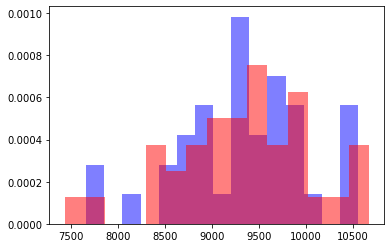

In [54]:
plt.hist(x = experiment.Pageviews,
        bins = 15,
        density = 1,
        facecolor = 'blue',
        alpha = 0.5)
plt.hist(x = control.Pageviews,
        bins = 15,
        density = 1,
        facecolor = 'red',
        alpha = 0.5)
# alpha is to set the transparent level 
plt.show()

A quick check of the pageviews distribution of the control and experiment group. 

## Sanity Checks

<a class="anchor" id="sanity"></a>
Sanity checks is to help verify that the experiment was conducted as expected and that other factors did not influence the data which we collected. This also makes sure that data collection was correct.

We have 3 Invariant metrics:: 
* Number of Cookies in Course Overview Page
* Number of Clicks on Free Trial Button
* Free Trial button Click-Through-Probability

Two of these metrics are simple counts: the number of cookies or number of clicks and the third is a probability (CTP). We will use two different ways of checking whether these obsereved values are like we expect. 

### Sanity Checks for differences between counts <a class="anchor" id="check_counts"></a>
**Number of cookies who viewed the course overview page** 
- Starting from this simpel invariant metric, we want to count the total amount of cookie pageviews we diverted to each group and see if there is a significant difference in the amount of cookies. A significant difference will imply a biased experiment that we should not rely on it's results.

The number of pageviews in the two groups are close. The next step is to ensure such difference in amount is not significant and random. Given we are expecting two groups are distributed with half and half amount, so we define a binominal random variable for a single experiment. We expect the probabily of 0.5 out of N experiments. 

We approaximate the binominal distribution to a normal distribution when n is large enough with a mean of p and $ SD$  = $\sqrt{\frac{p(1-p)}{N}}$
<center> <font size="4"> $ X$~$N( p,\sqrt{\frac{p(1-p)}{N}})$ </font></center> 

Our test goal: whether our observed $\hat{p}$ (number of samples in control divided by total number of damples in both groups) is not significantly different than $p=0.5$. In order to do that we can calculate the margin of error acceptable at a 95% confidence level:
<center> <font size="4"> $ ME=Z_{1-\frac{\alpha}{2}}SD$ </font></center>
Finally, a [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) can be derived to tell us in which range an observed $p$ can exist and be acceptable as "the same" as the expected value.
<center> <font size="4"> $ CI=[\hat{p}-ME,\hat{p}+ME]$ </font></center>
When our obsereved $\hat{p}$ is within this range, all is well and the test was passed.

In [55]:
# The toal number of pageviews in control and experiment groups
control_total_page = control.Pageviews.sum()
experiment_total_page = experiment.Pageviews.sum()
page_total = control_total_page + experiment_total_page
print("number of pageviews in the control group :", control_total_page)
print("number of Pageviews in the experiment group :" , experiment_total_page )
print("number of pageviews in total :", page_total)
# calculate the confidence interval 
p=0.5
alpha=0.05
p_hat=round(control_total_page/(page_total),4)
sd = np.sqrt(p * (1-p)/ (page_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"p_hat is ",p_hat)

number of pageviews in the control group : 345543.0
number of Pageviews in the experiment group : 344660
number of pageviews in total : 690203.0
The confidence interval is between 0.4988 and 0.5012 p_hat is  0.5006


**Number of cookies who clicked the Free Trial Button**

In [56]:
control_total_clicks = control.Clicks.sum()
experiment_total_clicks = experiment.Clicks.sum()
clicks_total = control_total_clicks + experiment_total_clicks

p_hat=round(control_total_clicks / clicks_total,4)
sd= np.sqrt(p*(1-p)/clicks_total)
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"and p_hat is",p_hat)

The confidence interval is between 0.4959 and 0.5041 and p_hat is 0.5005


### Sanity Checks for differences between probabilities

<a class="anchor" id="check_prob"></a>
** Click-through-probability of the Free Trial Button**

For the probabilities, we intend to test the proportion of clicks given a pageview (CTP) is about the same in both groups, meaning ($CTP_{exp}-CTP_{cont}=0$), with an acceptable margin of error, dictated by our calculated confidence interval. The calculation of the standard error is through the pooled standard error between experiment and control group. 

<center><font size="4">$SD_{pool}=\sqrt{\hat{p_{pool}}(1-\hat{p_{pool}})(\frac{1}{N_{cont}}+\frac{1}{N_{exp}})}$</f)ont></center>
with <br> <center><font size="5"> $\hat{p_{pool}}=\frac{x_{cont}+x_{exp}}{N_{cont}+N_{exp}}$ </font></center>

CTP is a proportion in a population (amount of events x in a population n) like the amount of clicks out of the amount of pageviews.

In [57]:
control_ctp = control_total_clicks / control_total_page
experiment_ctp = experiment_total_clicks / experiment_total_page
d_hat = round(experiment_ctp - control_ctp,4)
p_pooled = clicks_total / page_total
sd_pooled = np.sqrt( p_pooled * (1 - p_pooled) * (1/control.Pageviews.sum() + 1/experiment.Pageviews.sum())) 
ME=round(get_z_score(1-(alpha/2))*sd_pooled,4)
print ("The confidence interval is between",0-ME,"and",0+ME,"and d_hat is",d_hat)

The confidence interval is between -0.0013 and 0.0013 and d_hat is 0.0001


In summary, the sanity check result for the three invariant metrics are listed below: 

| Invariant Metric | Upper Bound | Lower Bound | Observed | 
|:-:|:-:|:-:|:-:|
| Number of Cookies in Course Overview Page | 0.4988  | 0.5012 | 0.5006 | 
| Number of Clicks on Free Trial Button | 0.4959 |  0.5041 | 0.5005 |
| Free Trial button CTP  |-0.0013 | 0.0013 | 0.0001 | 

Three observed values are within the confidence interval and thus three experiment result has passed the sanity check. 

## Examing Effect Size

<a class="anchor" id="effect"></a>
The next step is looking at the changes between the control and experiment groups with regard to our evaluation metrics to ensure the statistically significant difference and most importantly practically significant (the difference is "big" enough to make the experimented change beneficial to the company).

**Procedure**: 
1. Calculate pooled probability:
<center><font size="4">$\hat{p_{pool}}=\frac{x_{cont}+x_{exp}}{N_{cont}+N_{exp}}$ </font></center>
2. Calculate pooled standard devisation:
<center><font size="4">$SD_{pool}=\sqrt{\hat{p_{pool}}(1-\hat{p_{pool}})(\frac{1}{N_{cont}}+\frac{1}{N_{exp}})}$</font></center>
<br>
    
3. Calculate the practical significance difference 
<center><font size="4"> $\hat{d}=\frac{x_{exp}}{N_{exp}}-\frac{x_{cont}}{N_{cont}}$</font></center><br>

4. Calculate margin of errors:
<center> <font size="4"> $ ME=Z_{1-\frac{\alpha}{2}}SD$ </font></center>

5. Calculate Confidence Interval 
<center> <font size="4"> $ CI=[\hat{d}-ME,\hat{d}+ME]$ </font></center>

A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary or |d_hat| > dmin (that is, you can be confident there is a change that matters to the business.)

### Gross Conversion

* **Gross Conversion**

> **Important:** The given spreadsheet lists pageviews and clicks for 39 days, while it only lists enrollments and payments for 23 days. So, when working with enrollments and payments we should notice using only the corresponding pageviews and clicks, and not all of them.

In [58]:
# Count the total clicks from complete records only 
clicks_cont=control["Clicks"].loc[control["Enrollments"].notnull()].sum()
clicks_exp=experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()

#Gross Conversion - number of enrollments divided by number of clicks
enrollments_cont=control["Enrollments"].sum()
enrollments_exp=experiment["Enrollments"].sum()

# Check difference between GC_cont and GC_exp groups
GC_cont=enrollments_cont/clicks_cont
GC_exp=enrollments_exp/clicks_exp
GC_pooled=(enrollments_cont + enrollments_exp)/(clicks_cont + clicks_exp)
GC_sd_pooled= np.sqrt(GC_pooled*(1-GC_pooled)*(1/clicks_cont+1/clicks_exp))
GC_ME=round(get_z_score(1-alpha/2)*GC_sd_pooled,4)
GC_diff=round(GC_exp - GC_cont, 4)
print("The change due to the experiment is",GC_diff)
print("Confidence Interval: [",GC_diff-GC_ME,",",GC_diff+GC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to the experiment is -0.0206
Confidence Interval: [ -0.0292 , -0.012 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.01 is not in the CI as well.


According to this result there was a change due to the experiment, that change was both statistically and practically significant. 
We have a negative change of 2.06%, when we were willing to accept any change greater than 1%. This means the Gross Conversion rate of the experiment group (the one exposed to the change, i.e. asked how many hours they can devote to studying) has decreased as expected by 2% and this change was significant. This means  less people enrolled in the Free Trial after due to the pop-up. 

### Net Conversion 
We hypothesized the fraction of paid learners (out of the clicks)decrease in the experiment group. 

In [59]:
#Net Conversion - number of payments divided by number of clicks
payments_cont=control["Payments"].sum()
payments_exp=experiment["Payments"].sum()

NC_cont=payments_cont/clicks_cont
NC_exp=payments_exp/clicks_exp
NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
NC_sd_pooled=mt.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
NC_ME=round(get_z_score(1-alpha/2)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("The change due to the experiment is",NC_diff)
print("Confidence Interval: [",NC_diff-NC_ME,",",NC_diff+NC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",NC["d_min"],"is not in the CI as well.")

The change due to the experiment is -0.0049
Confidence Interval: [ -0.0116 , 0.0018000000000000004 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if 0.0075 is not in the CI as well.


In this case we got a change size of less than a 0.5%, a very small decrease which is not statistically significant, and as such not practically significant.

In summary, the effect size for the two evaluation metrics are listed below: 

| Evaluation Metric | Lower Bound | Upper Bound | Observed | dmin | Result|
|:-:|:-:|:-:|:-:|:-:|:-:|
| Gross Conversion | -0.0292  | -0.012 | -0.0206 | -0.01 | statistically significant & practically significant|
| Net Conversion | -0.0116 |  0.0018 | 0.0075 | -0.0049| Neither statistically significany or practically significant|


## Double Check with Sign Tests

<a class="anchor" id="sign_tests"></a>
A sign test is another method to validate the result obtained above. 
We check if the trend of change we observed (increase or decrease) was evident in the daily data. We are going to compute the metric's value per day and then count on how many days the metric was lower in the experiment group and this will be the number of success for the binomial variable. We then check the proportion of days of success out of all the available days.

### Data Preparation

In [60]:
# Prepare the dataset 
full = control.join(other=experiment, how = "inner", lsuffix= "_cont", rsuffix="_exp")
# full.head()
# filter the complete data records
full = full.loc[full["Enrollments_cont"].notnull()]
# full.count()
# assign the label=1 if experiment value is greater than the control value 
cont_x = full["Enrollments_cont"] / full["Clicks_cont"]
cont_y = full["Enrollments_exp"] / full["Clicks_exp"]
full["GC"] = np.where(cont_x < cont_y, 1, 0)
# full.GC
# build a column for netconversion 
cont_a = full["Payments_cont"] / full["Clicks_cont"]
cont_b = full["Payments_exp"] / full["Clicks_exp"]
full["NC"] = np.where(cont_a < cont_b, 1, 0)
# calculate the count 
GC_0 = full.GC[full["GC"] == 0].count()
NC_0 = full.NC[full["NC"] == 0].count()
n = full.GC.count()
print("No. of cases for GC:",GC_0,'\n',
      "No. of cases for NC:",NC_0,'\n',
      "No. of total cases",n)

No. of cases for GC: 19 
 No. of cases for NC: 13 
 No. of total cases 23


### Sign Test without the Online Calculator 

This part can be done using[online sign test calculator](https://www.graphpad.com/quickcalcs/binomial2/).

For Gross conversion, Number of "successes" you observed = 19,
                         Number of trials or experiments = 23,
                           Probability = 0.5,
                           The two-tail P value is 0.0026
                           , which means statistically significant

For Gross conversion, Number of "successes" you observed = 13
                         Number of trials or experiments = 23
                           Probability = 0.5
                           The two-tail P value is 0.6776,
                           which means NOT statistically significant

### Sign Test Result 

In summary, the sign test result is listed below:

| Evaluation Metric | p-value for sign test| statistically sig @ alpha = 0.5?|
|:-:|:-:|:-:|
| Gross Conversion | 0.0026  | Yes | 
| Net Conversion | 0.6776 |  No|

# Recommendation

For this experiment, we expect to reduce the number of frustrated students, instead of reducing the stuents who will make the payament after the free trial. However, our results shows that the Gross Conversion rates reduced by a lot. But the Net Conversion rate is not changing too much.

Given this reason, I suggest not launching the experiment.